# <font size=5> <strong>Heart Disease Prediction - AblationStudy(Feature Selection and SMOTE)
 

## 1. Importing Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import torch

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                            auc, confusion_matrix, classification_report, make_scorer)

# Modeling – XGBoost and TabNet
import xgboost as xgb
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Hyperparameter optimization
import optuna
from sklearn.model_selection import GridSearchCV

# Explainability
import shap
import random
import os
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
xgb.set_config(verbosity=0)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import keras_tuner as kt
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K


## 2. Data Preprocessing

### Importing datasets

In [2]:
df_A = pd.read_csv("Cleveland+Hungary+VA_long_beach+Switzerland.csv") # Source domain = multi-hospital dataset
df_B = pd.read_csv("Heart_disease_cleveland.csv")                     # Target domain = original Cleveland dataset

### Exploring and Inspecting Data sets

In [3]:
df_A.info() # Displays concise summary of DataFrame A: index range, column names, non-null counts, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        919 non-null    int64  
 1   age       919 non-null    int64  
 2   sex       919 non-null    object 
 3   dataset   919 non-null    object 
 4   cp        919 non-null    object 
 5   trestbps  919 non-null    float64
 6   chol      919 non-null    float64
 7   fbs       919 non-null    bool   
 8   restecg   919 non-null    object 
 9   thalch    919 non-null    float64
 10  exang     919 non-null    bool   
 11  oldpeak   919 non-null    float64
 12  slope     919 non-null    object 
 13  ca        919 non-null    float64
 14  thal      919 non-null    object 
 15  num       919 non-null    int64  
dtypes: bool(2), float64(5), int64(3), object(6)
memory usage: 102.4+ KB


In [4]:
df_B.info() # Displays concise summary of DataFrame B: index range, column names, non-null counts, and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


##### Cleaning and harmonizing information in datasets

In [5]:
BOLD = '\033[1m'
END = '\033[0m'

print(f"{BOLD}Datasets before preprocessing:{END}")

print(f"{BOLD}Multi-hospital Dataset:{END}")
# Changed .head() to .head(3)
print(f"{BOLD}{df_A.head(3).T.to_string(line_width=1000)}{END}")

print(f"\n{BOLD}Cleveland Dataset:{END}")
# Changed .head() to .head(3)
print(f"{BOLD}{df_B.head(3).T.to_string(line_width=1000)}{END}")

Datasets before preprocessing:
Multi-hospital Dataset:
                       0               1                  2
id                     1               2                  3
age                   63              67                 67
sex                 Male            Male               Male
dataset        Cleveland       Cleveland          Cleveland
cp        typical angina    asymptomatic       asymptomatic
trestbps           145.0           160.0              120.0
chol               233.0           286.0              229.0
fbs                 True           False              False
restecg   lv hypertrophy  lv hypertrophy     lv hypertrophy
thalch             150.0           108.0              129.0
exang              False            True               True
oldpeak              2.3             1.5                2.6
slope        downsloping            flat               flat
ca                   0.0             3.0                2.0
thal        fixed defect          normal  rev

In [6]:
# Remove Cleveland data from df_A before pretraining
df_A = df_A[df_A['dataset'] != 'Cleveland']

In [7]:
print(df_A.columns) # Prints the list of column names in DataFrame A.
print(df_B.columns) # Prints the list of column names in DataFrame B.

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [8]:
df_A = df_A.rename(columns={'thalch': 'thalach','num': 'target'}) #Rename columns in Dataset A to match Dataset B.

In [9]:
df_A = df_A.drop(columns=['id', 'dataset']) #Drop irrelevant columns in Dataset A (id, dataset).

In [10]:
# Convert target column in Dataset A to binary (0=no disease, 1=disease)
df_A['target'] = df_A['target'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# Map all categorical strings/booleans in Dataset A to numeric codes matching the target domain.
sex_map = {'Male': 1, 'Female': 0}

cp_map = {
    'typical angina': 0,
    'atypical angina': 1,
    'non-anginal': 2,
    'asymptomatic': 3
}

fbs_map = {True: 1, False: 0}

restecg_map = {
    'normal': 0,
    'st-t abnormality': 1,
    'lv hypertrophy': 2
}

exang_map = {True: 1, False: 0}

slope_map = {
    'upsloping': 0,
    'flat': 1,
    'downsloping': 2
}

thal_map = {
    'normal': 1,
    'fixed defect': 2,
    'reversable defect': 3
}

In [12]:
# Align features so both datasets have identical column names and encodings.
df_A['sex'] = df_A['sex'].map(sex_map)
df_A['cp'] = df_A['cp'].map(cp_map)
df_A['fbs'] = df_A['fbs'].map(fbs_map)
df_A['restecg'] = df_A['restecg'].map(restecg_map)
df_A['exang'] = df_A['exang'].map(exang_map)
df_A['slope'] = df_A['slope'].map(slope_map)
df_A['thal'] = df_A['thal'].map(thal_map)

In [13]:
# Final Check (Both should return zero missing values.)
print(df_A.isnull().sum())
print(df_B.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [14]:
#Do a final check for the target domain to ensure all columns are non-null.
df_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 304 to 918
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       615 non-null    int64  
 1   sex       615 non-null    int64  
 2   cp        615 non-null    int64  
 3   trestbps  615 non-null    float64
 4   chol      615 non-null    float64
 5   fbs       615 non-null    int64  
 6   restecg   615 non-null    int64  
 7   thalach   615 non-null    float64
 8   exang     615 non-null    int64  
 9   oldpeak   615 non-null    float64
 10  slope     615 non-null    int64  
 11  ca        615 non-null    float64
 12  thal      615 non-null    int64  
 13  target    615 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 72.1 KB


In [15]:
#Do a final check for the source domain to ensure all columns are non-null. 
df_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [58]:
# statistical measure about the dataset A
df_A.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,53.092683,0.842276,2.297561,133.209366,178.288276,0.151220,0.414634,130.435220,0.466667,0.942377,0.808130,0.422764,2.347967,0.600000
std,9.544659,0.364778,0.913655,18.305233,122.310526,0.358554,0.611066,24.077586,0.499294,1.099715,0.578326,0.689712,0.887421,0.490297
min,29.000000,0.000000,0.000000,80.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000,1.000000,0.000000
25%,47.000000,1.000000,2.000000,120.000000,0.000000,0.000000,0.000000,116.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,3.000000,130.000000,216.000000,0.000000,0.000000,129.000000,0.000000,0.700000,1.000000,0.000000,3.000000,1.000000
75%,60.000000,1.000000,3.000000,142.450000,263.000000,0.000000,1.000000,148.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,190.000000,1.000000,5.000000,2.000000,2.000000,3.000000,1.000000


In [59]:
# statistical measure about the dataset B
df_B.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [60]:
# Save cleanedup dataset A
df_A.to_csv("Preprocessed_Cleveland+Hungary+VA_long_beach+Switzerland.csv", index=False)

In [61]:
# Save cleanedup dataset B
df_B.to_csv("Preprocessed_Heart_disease_cleveland.csv", index=False)

In [62]:
BOLD = '\033[1m'
END = '\033[0m'

print(f"{BOLD}Datasets after preprocessing:{END}")

print(f"{BOLD}Multi-hospital Dataset:{END}")
# Changed .head() to .head(3)
print(f"{BOLD}{df_A.head(3).T.to_string(line_width=1000)}{END}")

print(f"\n{BOLD}Cleveland Dataset:{END}")
# Changed .head() to .head(3)
print(f"{BOLD}{df_B.head(3).T.to_string(line_width=1000)}{END}")

Datasets after preprocessing:
Multi-hospital Dataset:
            304     305    306
age        29.0   29.00   30.0
sex         1.0    1.00    0.0
cp          1.0    1.00    0.0
trestbps  120.0  140.00  170.0
chol      243.0  240.48  237.0
fbs         0.0    0.00    0.0
restecg     0.0    0.00    1.0
thalach   160.0  170.00  170.0
exang       0.0    0.00    0.0
oldpeak     0.0    0.00    0.0
slope       0.0    0.00    0.0
ca          0.0    0.00    0.0
thal        1.0    1.00    2.0
target      0.0    0.00    0.0

Cleveland Dataset:
              0      1      2
age        63.0   67.0   67.0
sex         1.0    1.0    1.0
cp          0.0    3.0    3.0
trestbps  145.0  160.0  120.0
chol      233.0  286.0  229.0
fbs         1.0    0.0    0.0
restecg     2.0    2.0    2.0
thalach   150.0  108.0  129.0
exang       0.0    1.0    1.0
oldpeak     2.3    1.5    2.6
slope       2.0    1.0    1.0
ca          0.0    3.0    2.0
thal        2.0    1.0    3.0
target      0.0    1.0    1.0


In [63]:
#Do a final check for dataset A to ensure all columns are non-null. 
df_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 304 to 918
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       615 non-null    int64  
 1   sex       615 non-null    int64  
 2   cp        615 non-null    int64  
 3   trestbps  615 non-null    float64
 4   chol      615 non-null    float64
 5   fbs       615 non-null    int64  
 6   restecg   615 non-null    int64  
 7   thalach   615 non-null    float64
 8   exang     615 non-null    int64  
 9   oldpeak   615 non-null    float64
 10  slope     615 non-null    int64  
 11  ca        615 non-null    float64
 12  thal      615 non-null    int64  
 13  target    615 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 72.1 KB


In [64]:
#Do a final check for dataset B to ensure all columns are non-null. 
df_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## 3. Data split and NO class imbalance handling

In [65]:
X_pretrain = df_A.drop('target', axis=1) 
y_pretrain = df_A['target']               

# Split the source domain into 80% train and 20% temp (for val+test)
X_pretrain_train, X_pretrain_temp, y_pretrain_train, y_pretrain_temp = train_test_split(
    X_pretrain, y_pretrain,
    test_size=0.2,          # 20% goes to temp (val+test)
    random_state=42,
    stratify=y_pretrain
)

# Split temp into 50% validation and 50% test → each 10% of total
X_pretrain_val, X_pretrain_test, y_pretrain_val, y_pretrain_test = train_test_split(
    X_pretrain_temp, y_pretrain_temp,
    test_size=0.5,          # half of temp = 10% of total
    random_state=42,
    stratify=y_pretrain_temp
)

# Target domain: Cleveland dataset for FINE-TUNING and evaluation
X_finetune = df_B.drop('target', axis=1)
y_finetune = df_B['target']


# Split target domain into 80% train and 20% temp (for val+test)
X_finetune_train, X_finetune_temp, y_finetune_train, y_finetune_temp = train_test_split(
    X_finetune, y_finetune,
    test_size=0.2,          # 20% goes to temp (val+test) 
    random_state=42,        # reproducible splits
    stratify=y_finetune     # preserve class distribution
)

# Split temp into 50% validation and 50% test → each 10% of total
X_finetune_val, X_finetune_test, y_finetune_val, y_finetune_test = train_test_split(
    X_finetune_temp, y_finetune_temp,
    test_size=0.5,          # 20% of training data will be used as the validation set
    random_state=42,        # reproducible splits
    stratify=y_finetune_temp  # preserve class distribution
)

In [66]:
print("## 📊 Source Domain Shapes ##")
print("---")

# Feature Matrix (X) Shapes
print("X_pretrain_train shape:", X_pretrain_train.shape)
print("X_pretrain_val   shape:", X_pretrain_val.shape)
print("X_pretrain_test  shape:", X_pretrain_test.shape)
print("Total X rows:", 
      X_pretrain_train.shape[0] + X_pretrain_val.shape[0] + X_pretrain_test.shape[0]
)

print("\n")

# Target Vector (y) Shapes
print("y_pretrain_train shape:", y_pretrain_train.shape)
print("y_pretrain_val   shape:", y_pretrain_val.shape)
print("y_pretrain_test  shape:", y_pretrain_test.shape)


## --- Target domain Splits ---
print("\n## 🎯 Target Domain Shapes ##")
print("---")

# Feature Matrix (X) Shapes
print("X_finetune_train shape:", X_finetune_train.shape)
print("X_finetune_val   shape:", X_finetune_val.shape)
print("X_finetune_test  shape:", X_finetune_test.shape)
print("Total X rows:", 
      X_finetune_train.shape[0] + X_finetune_val.shape[0] + X_finetune_test.shape[0]
)

print("\n")

# Target Vector (y) Shapes
print("y_finetune_train shape:", y_finetune_train.shape)
print("y_finetune_val   shape:", y_finetune_val.shape)
print("y_finetune_test  shape:", y_finetune_test.shape)

## 📊 Source Domain Shapes ##
---
X_pretrain_train shape: (492, 13)
X_pretrain_val   shape: (61, 13)
X_pretrain_test  shape: (62, 13)
Total X rows: 615


y_pretrain_train shape: (492,)
y_pretrain_val   shape: (61,)
y_pretrain_test  shape: (62,)

## 🎯 Target Domain Shapes ##
---
X_finetune_train shape: (242, 13)
X_finetune_val   shape: (30, 13)
X_finetune_test  shape: (31, 13)
Total X rows: 303


y_finetune_train shape: (242,)
y_finetune_val   shape: (30,)
y_finetune_test  shape: (31,)


## 4. XGBoost

### Pretraining on the source domain

In [67]:
# Define the best parameters found during the Grid Search for pretraining on Dataset A
best_pretrain_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.01,
    'max_depth': 8,
    'n_estimators': 300,
    'reg_alpha': 0.1, 
    'reg_lambda': 0.5, 
    'subsample': 1.0
}

# Best parameters for pretraining: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6,
#                                   'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
# Best F1-score: 0.8647


In [68]:
# Get the best parameters
# best_pretrain_params = grid_search.best_params_

for param, value in best_pretrain_params.items():
    print(f"  {param}: {value}")

# Create and train fresh model
xgb_pretrain = xgb.XGBClassifier(
    **best_pretrain_params,
    eval_metric='logloss',
    random_state=42,
    seed = 42,
    early_stopping_rounds=50
)

xgb_pretrain.fit(
    X_pretrain_train,
    y_pretrain_train,
    eval_set=[(X_pretrain_val, y_pretrain_val)],
    verbose=1  # Show progress every 100 trees
)

  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 8
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 0.5
  subsample: 1.0
[0]	validation_0-logloss:0.66624
[1]	validation_0-logloss:0.66229
[2]	validation_0-logloss:0.65750
[3]	validation_0-logloss:0.65223
[4]	validation_0-logloss:0.64784
[5]	validation_0-logloss:0.64344
[6]	validation_0-logloss:0.63863
[7]	validation_0-logloss:0.63429
[8]	validation_0-logloss:0.63087
[9]	validation_0-logloss:0.62699
[10]	validation_0-logloss:0.62453
[11]	validation_0-logloss:0.62045
[12]	validation_0-logloss:0.61704
[13]	validation_0-logloss:0.61283
[14]	validation_0-logloss:0.60925
[15]	validation_0-logloss:0.60645
[16]	validation_0-logloss:0.60294
[17]	validation_0-logloss:0.60002
[18]	validation_0-logloss:0.59610
[19]	validation_0-logloss:0.59220
[20]	validation_0-logloss:0.58906
[21]	validation_0-logloss:0.58540
[22]	validation_0-logloss:0.58208
[23]	validation_0-logloss:0.57957
[24]	validation_0-logloss:0.57656
[25]	validation_0-logloss:0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [69]:
# PRETRAINED MODEL EVALUATION ON A-TEST
Dataset_A_Pretrain = xgb_pretrain.predict(X_pretrain_test)

#Calculate and print metrics on source domain's test set
Dataset_A_Pretrain_acc = accuracy_score(y_pretrain_test, Dataset_A_Pretrain) * 100
Dataset_A_Pretrain_f1  = f1_score(y_pretrain_test, Dataset_A_Pretrain) * 100

cm_A = confusion_matrix(y_pretrain_test, Dataset_A_Pretrain)
TN_A, FP_A, FN_A, TP_A = cm_A.ravel()


recall_A = TP_A / (TP_A + FN_A) * 100
specificity_A = TN_A / (TN_A + FP_A) * 100
print(f"Pretraining Test Accuracy on Source domain: {Dataset_A_Pretrain_acc:.2f}%")
print(f"Pretraining Test F1 on Source domain: {Dataset_A_Pretrain_f1:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on Source domain: {recall_A:.2f}%")
print(f"Pretraining Test Specificity on Source domain: {specificity_A:.2f}%")

Pretraining Test Accuracy on Source domain: 79.03%
Pretraining Test F1 on Source domain: 83.95%
Pretraining Test Recall (Sensitivity) on Source domain: 91.89%
Pretraining Test Specificity on Source domain: 60.00%


In [70]:
Dataset_B_Pretrain = xgb_pretrain.predict(X_finetune_test)

#Calculate and print metrics on target domain's test set
Dataset_B_Pretrain_acc = accuracy_score(y_finetune_test, Dataset_B_Pretrain) * 100
Dataset_B_Pretrain_f1 = f1_score(y_finetune_test, Dataset_B_Pretrain) * 100
cm_B = confusion_matrix(y_finetune_test, Dataset_B_Pretrain)
TN_B, FP_B, FN_B, TP_B = cm_B.ravel()
recall_B = TP_B / (TP_B + FN_B) * 100
specificity_B = TN_B / (TN_B + FP_B) * 100

print(f"Pretraining Accuracy on target domain's test Set: {Dataset_B_Pretrain_acc:.2f}%")
print(f"Pretraining F1 on target domain's test Set: {Dataset_B_Pretrain_f1:.2f}%")
print(f"Pretraining Recall (Sensitivity) on target domain's test Set: {recall_B:.2f}%")
print(f"Pretraining Specificity on target domain's test Set: {specificity_B:.2f}%")

Pretraining Accuracy on target domain's test Set: 74.19%
Pretraining F1 on target domain's test Set: 75.00%
Pretraining Recall (Sensitivity) on target domain's test Set: 85.71%
Pretraining Specificity on target domain's test Set: 64.71%


### Finetuning on the target domain

In [71]:
best_finetune_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.009,
    'max_depth': 6,
    'n_estimators': 300,
    'reg_alpha': 0.1, 
    'reg_lambda': 1.5, 
    'subsample': 1.0
}

In [72]:
# Get the best parameters from fine-tuning grid search
# best_finetune_params = grid_search_finetune.best_params_

for param, value in best_finetune_params.items():
    print(f"  {param}: {value}")

xgb_finetune = xgb.XGBClassifier(
    **best_finetune_params,
    eval_metric='logloss',
    random_state=42,
    seed = 42,
    early_stopping_rounds=50
)

xgb_finetune.fit(
    X_finetune_train,
    y_finetune_train, 
    eval_set=[(X_finetune_val, y_finetune_val)], 
    xgb_model=xgb_pretrain.get_booster(),
    verbose=1 
)

  colsample_bytree: 0.7
  learning_rate: 0.009
  max_depth: 6
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 1.5
  subsample: 1.0
[0]	validation_0-logloss:0.27185
[1]	validation_0-logloss:0.27044
[2]	validation_0-logloss:0.26975
[3]	validation_0-logloss:0.26819
[4]	validation_0-logloss:0.26676
[5]	validation_0-logloss:0.26586
[6]	validation_0-logloss:0.26484
[7]	validation_0-logloss:0.26399
[8]	validation_0-logloss:0.26316
[9]	validation_0-logloss:0.26267
[10]	validation_0-logloss:0.26143
[11]	validation_0-logloss:0.25991
[12]	validation_0-logloss:0.25857
[13]	validation_0-logloss:0.25733
[14]	validation_0-logloss:0.25678
[15]	validation_0-logloss:0.25556
[16]	validation_0-logloss:0.25493
[17]	validation_0-logloss:0.25391
[18]	validation_0-logloss:0.25324
[19]	validation_0-logloss:0.25280
[20]	validation_0-logloss:0.25188
[21]	validation_0-logloss:0.25058
[22]	validation_0-logloss:0.24949
[23]	validation_0-logloss:0.24878
[24]	validation_0-logloss:0.24778
[25]	validation_0-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [73]:
# FINE-TUNED MODEL EVALUATION ON A-TEST (Checking for Catastrophic Forgetting)
Dataset_A_Finetune = xgb_finetune.predict(X_pretrain_test) # Using the fine-tuned model on A's test set

# Calculate and print metrics on source domain's test set
acc_A_Finetune = accuracy_score(y_pretrain_test, Dataset_A_Finetune) * 100
f1_A_Finetune = f1_score(y_pretrain_test, Dataset_A_Finetune) * 100

cm_A_Finetune = confusion_matrix(y_pretrain_test, Dataset_A_Finetune)
TN_A_F, FP_A_F, FN_A_F, TP_A_F = cm_A_Finetune.ravel()

recall_A_Finetune = TP_A_F / (TP_A_F + FN_A_F) * 100
specificity_A_Finetune = TN_A_F / (TN_A_F + FP_A_F) * 100

print(f"Fine-Tuning Test Accuracy on Source domain: {acc_A_Finetune:.2f}%")
print(f"Fine-Tuning Test F1 on Source domain: {f1_A_Finetune:.2f}%")
print(f"Fine-Tuning Test Recall (Sensitivity) on Source domain: {recall_A_Finetune:.2f}%")
print(f"Fine-Tuning Test Specificity on Source domain: {specificity_A_Finetune:.2f}%")

Fine-Tuning Test Accuracy on Source domain: 80.65%
Fine-Tuning Test F1 on Source domain: 85.00%
Fine-Tuning Test Recall (Sensitivity) on Source domain: 91.89%
Fine-Tuning Test Specificity on Source domain: 64.00%


In [74]:
# FINE-TUNED MODEL EVALUATION ON B-TEST (Final Transfer Learning Performance)
Dataset_B_Finetune = xgb_finetune.predict(X_finetune_test) # Using the fine-tuned model on B's test set

# Calculate and print metrics on target domain's test set
acc_B_Finetune = accuracy_score(y_finetune_test, Dataset_B_Finetune) * 100
f1_B_Finetune = f1_score(y_finetune_test, Dataset_B_Finetune) * 100

cm_B_Finetune = confusion_matrix(y_finetune_test, Dataset_B_Finetune)
TN_B_F, FP_B_F, FN_B_F, TP_B_F = cm_B_Finetune.ravel()

recall_B_Finetune = TP_B_F / (TP_B_F + FN_B_F) * 100
specificity_B_Finetune = TN_B_F / (TN_B_F + FP_B_F) * 100
roc_auc_B_Finetune = roc_auc_score(y_finetune_test, Dataset_B_Finetune) * 100

print(f"Fine-Tuning Test ROC-AUC on Target domain (B): {roc_auc_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Accuracy on Target domain (B): {acc_B_Finetune:.2f}%")
print(f"Fine-Tuning Test F1 on Target domain (B): {f1_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Recall (Sensitivity) on Target domain (B): {recall_B_Finetune:.2f}%")
print(f"Fine-Tuning Test Specificity on Target domain (B): {specificity_B_Finetune:.2f}%")

Fine-Tuning Test ROC-AUC on Target domain (B): 81.72%
Fine-Tuning Test Accuracy on Target domain (B): 80.65%
Fine-Tuning Test F1 on Target domain (B): 81.25%
Fine-Tuning Test Recall (Sensitivity) on Target domain (B): 92.86%
Fine-Tuning Test Specificity on Target domain (B): 70.59%


#### SHAP figure from the proposed model

In [ ]:
# Set global font to Times New Roman
plt.rcParams.update({'font.family': 'Times New Roman'})

# Create SHAP explainer for XGBoost model
explainer = shap.TreeExplainer(xgb_finetune)

# Calculate SHAP values
shap_values = explainer(X_finetune_test)

# Create a larger figure
plt.figure(figsize=(14, 8))

# Generate summary plot with custom settings, no caption
shap.summary_plot(shap_values, X_finetune_test, 
                  max_display=20,  # Show top 20 features
                  show=False)

# Customize the plot
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

# Save the plot as an image with high resolution and no caption
plt.savefig('shap_summary_xgboost.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()


### Confusion matrix and ROC-AUC curve for the proposed model

In [ ]:
# Set global font to Times New Roman
# plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Assuming y_finetune_test and Dataset_B_Finetune are already defined
cm = confusion_matrix(y_finetune_test, Dataset_B_Finetune)

# Unravel the confusion matrix to get TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5, 4))
im = plt.imshow(cm, cmap='Blues', interpolation='nearest') 

vmax = cm.max()
colorbar_ticks = np.arange(0, vmax + 10, 10)
plt.colorbar(im, ticks=colorbar_ticks)

# plt.title('Confusion Matrix of the fine-tuned model')

ax = plt.gca()
# ax.invert_yaxis()  # You can uncomment this if you want to invert the Y-axis

# Set X-axis labels (Predicted: Disease then No Disease)
plt.xticks([0, 1], ['No Disease', 'Disease']) 
plt.yticks([0, 1], ['No Disease', 'Disease']) 

plt.ylabel('Actual')
plt.xlabel('Predicted')

# Dynamic text color for contrast
norm = mcolors.Normalize(vmin=cm.min(), vmax=cm.max())
cmap = plt.colormaps['Blues']

for i in range(2):
    for j in range(2):
        cell_value = cm[i, j]
        cell_color = cmap(norm(cell_value))
        luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]
        text_color = 'white' if luminance < 0.5 else 'black'
        
        # Set the text in Times New Roman
        plt.text(j, i, f'{cell_value}', ha='center', va='center', color=text_color, fontsize=24, fontweight='bold')

# Save the confusion matrix image
plt.savefig('confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_finetune_test, Dataset_B_Finetune) * 100
recall = recall_score(y_finetune_test, Dataset_B_Finetune) * 100
f1 = f1_score(y_finetune_test, Dataset_B_Finetune) * 100

# Calculate Specificity: TN / (TN + FP)
specificity = (tn / (tn + fp)) * 100

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_finetune_test, Dataset_B_Finetune) * 100

print(f"ROC-AUC: {roc_auc:.2f}%")

# Plot ROC curve with blue tones (IEEE standard)
fpr, tpr, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(7, 6))

# Plot the ROC curve: Use 'orange' color and update the label
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')

# Set limits and labels as in the original image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') # Changed back to match the image axis label

# Adjust legend location to match the original image
plt.legend(loc='lower right')

# Save the ROC curve image (you can keep your original filename or update it)
plt.savefig('roc_curve_xgboost.png', dpi=300, bbox_inches='tight')
plt.close()

### XGBoost with no Transfer Learning

In [75]:
baseline_model = XGBClassifier(
    # 'colsample_bytree': 0.7,
    # 'learning_rate': 0.009,
    # 'max_depth': 6,
    # 'n_estimators': 300,
    # 'reg_alpha': 0.1, 
    # 'reg_lambda': 1.5, 
    # 'subsample': 1.0
    n_estimators=300,            
    max_depth=10,
    learning_rate=0.001,          # slightly higher for adaptation
    subsample=1.0,
    seed=42,
    colsample_bytree=0.7,
    eval_metric='logloss',
    reg_lambda = 1.5,
    reg_alpha = 0.1,
    early_stopping_rounds=50,
    random_state=42
)

# Train using only Dataset B (resampled training set)
baseline_model.fit(
    X_finetune_train,
    y_finetune_train,
    eval_set=[(X_finetune_val, y_finetune_val)]
)

[0]	validation_0-logloss:0.69079
[1]	validation_0-logloss:0.69034
[2]	validation_0-logloss:0.68981
[3]	validation_0-logloss:0.68941
[4]	validation_0-logloss:0.68885
[5]	validation_0-logloss:0.68831
[6]	validation_0-logloss:0.68795
[7]	validation_0-logloss:0.68741
[8]	validation_0-logloss:0.68698
[9]	validation_0-logloss:0.68645
[10]	validation_0-logloss:0.68608
[11]	validation_0-logloss:0.68561
[12]	validation_0-logloss:0.68514
[13]	validation_0-logloss:0.68471
[14]	validation_0-logloss:0.68417
[15]	validation_0-logloss:0.68380
[16]	validation_0-logloss:0.68330
[17]	validation_0-logloss:0.68293
[18]	validation_0-logloss:0.68257
[19]	validation_0-logloss:0.68216
[20]	validation_0-logloss:0.68179
[21]	validation_0-logloss:0.68139
[22]	validation_0-logloss:0.68098
[23]	validation_0-logloss:0.68048
[24]	validation_0-logloss:0.68001
[25]	validation_0-logloss:0.67964
[26]	validation_0-logloss:0.67912
[27]	validation_0-logloss:0.67866
[28]	validation_0-logloss:0.67829
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [76]:
# Evaluate on Dataset B test set
y_pred_baseline = baseline_model.predict(X_finetune_test)

baseline_acc = accuracy_score(y_finetune_test, y_pred_baseline) * 100
baseline_f1  = f1_score(y_finetune_test, y_pred_baseline) * 100

cm = confusion_matrix(y_finetune_test, y_pred_baseline)
TN, FP, FN, TP = cm.ravel()

recall_score_calc = TP / (TP + FN) * 100
specificity_score_calc = TN / (TN + FP) * 100


print(f"Baseline Accuracy (Dataset B): {baseline_acc:.2f}%")
print(f"Baseline F1-score (Dataset B): {baseline_f1:.2f}%")
print(f"Baseline Recall (Sensitivity): {recall_score_calc:.2f}%")
print(f"Baseline Specificity: {specificity_score_calc:.2f}%")

Baseline Accuracy (Dataset B): 80.65%
Baseline F1-score (Dataset B): 76.92%
Baseline Recall (Sensitivity): 71.43%
Baseline Specificity: 88.24%


## 5. Tabnet

In [77]:
def set_all_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_all_seeds(42)

In [78]:
# Defining the training, validation, and test datasets for the source domain
X_A_train = X_pretrain_train.values  # Features for training on the source domain (pre-training phase)
y_A_train = y_pretrain_train.values  # Target labels for training on the source domain

X_A_val   = X_pretrain_val.values  # Features for validation on the source domain
y_A_val   = y_pretrain_val.values  # Target labels for validation on the source domain

X_A_test  = X_pretrain_test.values  # Features for testing on the source domain
y_A_test  = y_pretrain_test.values  # Target labels for testing on the source domain

# Defining the training, validation, and test datasets for the target domain
X_B_train = X_finetune_train.values  # Features for training on the target domain (fine-tuning phase)
y_B_train = y_finetune_train.values  # Target labels for training on the target domain

X_B_val   = X_finetune_val.values  # Features for validation on the target domain
y_B_val   = y_finetune_val.values  # Target labels for validation on the target domain

X_B_test  = X_finetune_test.values  # Features for testing on the target domain
y_B_test  = y_finetune_test.values  # Target labels for testing on the target domain

In [79]:
scaler = StandardScaler()

X_A_train = scaler.fit_transform(X_A_train).astype(np.float32)  # Fit scaler on source train set, transform it
X_A_val = scaler.transform(X_A_val).astype(np.float32)          # Transform source validation set
X_A_test = scaler.transform(X_A_test).astype(np.float32)        # Transform source test set

y_A_train = y_A_train.astype(np.int64)  # Convert source train labels to int64
y_A_val = y_A_val.astype(np.int64)      # Convert source validation labels
y_A_test = y_A_test.astype(np.int64)    # Convert source test labels

X_B_train = scaler.transform(X_B_train).astype(np.float32)      # Apply source-domain scaling to target train set
X_B_val = scaler.transform(X_B_val).astype(np.float32)          # Apply scaling to target validation set
X_B_test = scaler.transform(X_B_test).astype(np.float32)        # Apply scaling to target test set

y_B_train = y_B_train.astype(np.int64)  # Convert target train labels to int64
y_B_val = y_B_val.astype(np.int64)      # Convert target validation labels
y_B_test = y_B_test.astype(np.int64)    # Convert target test labels

In [80]:
best_pretrain_params = {
    "n_d_a": 16,
    "n_steps": 9,
    "gamma": 1.7899467948557366,
    "lambda_sparse": 4.387608964907318e-05,
    "lr": 0.003074702431245894,
    "momentum": 0.22,
    "batch_size": 32,
    "virtual_batch_size": 32,
    "step_size": 40,
    "scheduler_gamma": 0.9464940708357479,
}
for key, value in best_pretrain_params.items():
    print(f"{key}: {value}")

n_d_a: 16
n_steps: 9
gamma: 1.7899467948557366
lambda_sparse: 4.387608964907318e-05
lr: 0.003074702431245894
momentum: 0.22
batch_size: 32
virtual_batch_size: 32
step_size: 40
scheduler_gamma: 0.9464940708357479


In [81]:
# best_params = study_scratch.best_params

tabnet_pretrain = TabNetClassifier(
    n_d=best_pretrain_params['n_d_a'],           # split n_d_a into n_d
    n_a=best_pretrain_params['n_d_a'],           # and n_a
    n_steps=best_pretrain_params['n_steps'],
    gamma=best_pretrain_params['gamma'],
    lambda_sparse=best_pretrain_params['lambda_sparse'],
    momentum=best_pretrain_params['momentum'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': best_pretrain_params['lr']},
    mask_type='sparsemax',
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={'step_size': best_pretrain_params['step_size'], 'gamma': best_pretrain_params['scheduler_gamma']},
    verbose=1,
    seed=42
)


# Train the final model
tabnet_pretrain.fit(
    X_train=X_A_train,
    y_train=y_A_train,
    eval_set=[(X_A_val, y_A_val)],
    eval_name=["val"],
    eval_metric=["logloss"],
    max_epochs=150,
    patience=30,
    batch_size=best_pretrain_params['batch_size'],
    virtual_batch_size=best_pretrain_params['virtual_batch_size'],
    num_workers=0,
    drop_last=False
)

# Save the trained model
tabnet_pretrain.save_model("tabnet_pretrain_model")

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27448 | val_logloss: 0.80151 |  0:00:00s
epoch 1  | loss: 0.90652 | val_logloss: 0.94948 |  0:00:01s
epoch 2  | loss: 0.767   | val_logloss: 0.55012 |  0:00:02s
epoch 3  | loss: 0.75719 | val_logloss: 0.90148 |  0:00:03s
epoch 4  | loss: 0.70271 | val_logloss: 0.83693 |  0:00:04s
epoch 5  | loss: 0.69054 | val_logloss: 0.64045 |  0:00:04s
epoch 6  | loss: 0.64496 | val_logloss: 0.80293 |  0:00:05s
epoch 7  | loss: 0.57968 | val_logloss: 0.60868 |  0:00:06s
epoch 8  | loss: 0.68451 | val_logloss: 0.84744 |  0:00:07s
epoch 9  | loss: 0.656   | val_logloss: 0.81741 |  0:00:08s
epoch 10 | loss: 0.6109  | val_logloss: 0.72011 |  0:00:08s
epoch 11 | loss: 0.55664 | val_logloss: 0.78506 |  0:00:09s
epoch 12 | loss: 0.51877 | val_logloss: 0.61658 |  0:00:10s
epoch 13 | loss: 0.52401 | val_logloss: 0.55633 |  0:00:11s
epoch 14 | loss: 0.50404 | val_logloss: 0.63907 |  0:00:12s
epoch 15 | loss: 0.54062 | val_logloss: 0.76155 |  0:00:12s
epoch 16 | loss: 0.54955 | val_logloss: 

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at tabnet_pretrain_model.zip


'tabnet_pretrain_model.zip'

In [82]:
Dataset_A_Pretrain_TNet = tabnet_pretrain.predict(X_A_test)

cm_A_TNet = confusion_matrix(y_A_test, Dataset_A_Pretrain_TNet)
TN_A, FP_A, FN_A, TP_A = cm_A_TNet.ravel()

# Calculate Metrics for TabNet on Dataset A
acc_A_TNet = accuracy_score(y_A_test, Dataset_A_Pretrain_TNet) * 100
f1_A_TNet = f1_score(y_A_test, Dataset_A_Pretrain_TNet) * 100
recall_A_TNet = TP_A / (TP_A + FN_A) * 100
specificity_A_TNet = TN_A / (TN_A + FP_A) * 100


print(f"Pre-training, test on Dataset A, Test Accuracy: {acc_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test F1-score: {f1_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test Recall (Sensitivity): {recall_A_TNet:.2f}%")
print(f"Pre-training, test on Dataset A, Test Specificity: {specificity_A_TNet:.2f}%")

Pre-training, test on Dataset A, Test Accuracy: 79.03%
Pre-training, test on Dataset A, Test F1-score: 82.19%
Pre-training, test on Dataset A, Test Recall (Sensitivity): 81.08%
Pre-training, test on Dataset A, Test Specificity: 76.00%


In [83]:
Dataset_B_Pretrain_TNet = tabnet_pretrain.predict(X_B_test)

# Calculate Confusion Matrix for TabNet on Dataset B
# Structure: [[TN, FP], [FN, TP]]
cm_B_TNet = confusion_matrix(y_B_test, Dataset_B_Pretrain_TNet)
TN_B, FP_B, FN_B, TP_B = cm_B_TNet.ravel()

# Calculate Core Metrics
acc_B_TNet = accuracy_score(y_B_test, Dataset_B_Pretrain_TNet) * 100
f1_B_TNet = f1_score(y_B_test, Dataset_B_Pretrain_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_B_TNet = TP_B / (TP_B + FN_B) * 100
specificity_B_TNet = TN_B / (TN_B + FP_B) * 100

print(f"Pre-training, test on Dataset B, Accuracy: {acc_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, F1-score: {f1_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, Recall (Sensitivity): {recall_B_TNet:.2f}%")
print(f"Pre-training, test on Dataset B, Specificity: {specificity_B_TNet:.2f}%")


Pre-training, test on Dataset B, Accuracy: 83.87%
Pre-training, test on Dataset B, F1-score: 81.48%
Pre-training, test on Dataset B, Recall (Sensitivity): 78.57%
Pre-training, test on Dataset B, Specificity: 88.24%


In [84]:
best_finetune_params = {
    "gamma": 1.8676698399014517,
    "lambda_sparse": 0.0042824862550021525,
    "lr": 0.0013627631079900058,
    "momentum": 0.92,
    "batch_size": 32,
    "virtual_batch_size": 32,
    "step_size": 10,
    "scheduler_gamma": 0.8296240533908424,
}
for key, value in best_finetune_params.items():
    print(f"{key}: {value}")

gamma: 1.8676698399014517
lambda_sparse: 0.0042824862550021525
lr: 0.0013627631079900057
momentum: 0.92
batch_size: 32
virtual_batch_size: 32
step_size: 10
scheduler_gamma: 0.8296240533908424


In [85]:
# best_finetune_params = study_finetune.best_params

# Create a new model for fine-tuning
tabnet_finetuned = TabNetClassifier(
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=best_finetune_params['gamma'],
    lambda_sparse=best_finetune_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={
        'lr': best_finetune_params['lr']
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={'step_size': best_finetune_params['step_size'], 'gamma': best_finetune_params['scheduler_gamma']},
    seed=42,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)
tabnet_finetuned.fit(
    X_train=X_B_train,
    y_train=y_B_train,           
    eval_set=[(X_B_val, y_B_val)],
    eval_name=["val"],
    eval_metric=['logloss'],
    max_epochs=100,
    patience=40,
    batch_size=best_finetune_params['batch_size'],
    virtual_batch_size=best_finetune_params['virtual_batch_size'],
    num_workers=0,
    drop_last=False,
    # Initialize with pre-trained weights
    from_unsupervised=tabnet_pretrain  # Transfer learning!
)

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 3 to 9
  warnings.warn(wrn_msg)
C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.6337  | val_logloss: 0.29008 |  0:00:00s
epoch 1  | loss: 0.61888 | val_logloss: 0.22487 |  0:00:00s
epoch 2  | loss: 0.66477 | val_logloss: 0.23841 |  0:00:01s
epoch 3  | loss: 0.57045 | val_logloss: 0.26257 |  0:00:01s
epoch 4  | loss: 0.5691  | val_logloss: 0.25684 |  0:00:02s
epoch 5  | loss: 0.54943 | val_logloss: 0.39612 |  0:00:02s
epoch 6  | loss: 0.57882 | val_logloss: 0.37099 |  0:00:03s
epoch 7  | loss: 0.53552 | val_logloss: 0.35785 |  0:00:03s
epoch 8  | loss: 0.50991 | val_logloss: 0.55618 |  0:00:03s
epoch 9  | loss: 0.57154 | val_logloss: 0.51816 |  0:00:04s
epoch 10 | loss: 0.56153 | val_logloss: 0.47322 |  0:00:04s
epoch 11 | loss: 0.54187 | val_logloss: 0.4601  |  0:00:05s
epoch 12 | loss: 0.51525 | val_logloss: 0.4153  |  0:00:05s
epoch 13 | loss: 0.52878 | val_logloss: 0.39446 |  0:00:05s
epoch 14 | loss: 0.51475 | val_logloss: 0.35433 |  0:00:06s
epoch 15 | loss: 0.4903  | val_logloss: 0.44938 |  0:00:06s
epoch 16 | loss: 0.48271 | val_logloss: 

C:\Users\prosp\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [86]:
Dataset_A_Finetune_TNet = tabnet_finetuned.predict(X_A_test)

# Calculate Confusion Matrix for Fine-Tuned TabNet on Dataset A
# Structure: [[TN, FP], [FN, TP]]
cm_A_Finetune_TNet = confusion_matrix(y_A_test, Dataset_A_Finetune_TNet)
TN_A_F, FP_A_F, FN_A_F, TP_A_F = cm_A_Finetune_TNet.ravel()

# Calculate Core Metrics
acc_A_Finetune_TNet = accuracy_score(y_A_test, Dataset_A_Finetune_TNet) * 100
f1_A_Finetune_TNet = f1_score(y_A_test, Dataset_A_Finetune_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_A_Finetune_TNet = TP_A_F / (TP_A_F + FN_A_F) * 100 if (TP_A_F + FN_A_F) > 0 else 0
specificity_A_Finetune_TNet = TN_A_F / (TN_A_F + FP_A_F) * 100 if (TN_A_F + FP_A_F) > 0 else 0

print(f"Fine-tuned, test on Dataset A, Test Accuracy: {acc_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test F1-score: {f1_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test Recall (Sensitivity): {recall_A_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset A, Test Specificity: {specificity_A_Finetune_TNet:.2f}%")

Fine-tuned, test on Dataset A, Test Accuracy: 80.65%
Fine-tuned, test on Dataset A, Test F1-score: 84.21%
Fine-tuned, test on Dataset A, Test Recall (Sensitivity): 86.49%
Fine-tuned, test on Dataset A, Test Specificity: 72.00%


In [87]:
Dataset_B_Finetune_TNet = tabnet_finetuned.predict(X_B_test)

# Calculate Confusion Matrix for Fine-Tuned TabNet on Dataset B
# Structure: [[TN, FP], [FN, TP]]
cm_B_Finetune_TNet = confusion_matrix(y_B_test, Dataset_B_Finetune_TNet)
TN_F, FP_F, FN_F, TP_F = cm_B_Finetune_TNet.ravel()

# Calculate Core Metrics
acc_B_Finetune_TNet = accuracy_score(y_B_test, Dataset_B_Finetune_TNet) * 100
f1_B_Finetune_TNet = f1_score(y_B_test, Dataset_B_Finetune_TNet) * 100

# Calculate Recall (Sensitivity) and Specificity
recall_B_Finetune_TNet = TP_F / (TP_F + FN_F) * 100
specificity_B_Finetune_TNet = TN_F / (TN_F + FP_F) * 100

print(f"Fine-tuned, test on Dataset B, Accuracy: {acc_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, F1-score: {f1_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, Recall (Sensitivity): {recall_B_Finetune_TNet:.2f}%")
print(f"Fine-tuned, test on Dataset B, Specificity: {specificity_B_Finetune_TNet:.2f}%")

Fine-tuned, test on Dataset B, Accuracy: 77.42%
Fine-tuned, test on Dataset B, F1-score: 74.07%
Fine-tuned, test on Dataset B, Recall (Sensitivity): 71.43%
Fine-tuned, test on Dataset B, Specificity: 82.35%


## 6. MLP

### Pretraining phase

In [88]:
best_params = {
    'learning_rate' : 0.01,
    'l2_reg' : 0.0001,
    'neurons_l1' : 128,
    'dropout_rate' : 0.1
}

In [89]:
def create_mlp_model(input_shape, best_params):
    neurons_l1 = best_params['neurons_l1']
    dropout_rate = best_params['dropout_rate']
    l2_reg = best_params['l2_reg']
    learning_rate = best_params['learning_rate']

    inputs = Input(shape=(input_shape,))
    x = Dense(neurons_l1, activation='relu', name='feature_layer_1', kernel_regularizer=keras.regularizers.l2(l2_reg))(inputs)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(int(neurons_l1/2), activation='relu', name='feature_layer_2', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(int(neurons_l1/4), activation='relu', name='feature_layer_3', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1, activation='sigmoid', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

input_dim = X_pretrain_train.shape[1]
mlp_pretrain = create_mlp_model(input_dim, best_params)
mlp_pretrain.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_1 (Dense)              │ (None, 128)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_2 (Dense)              │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_3 (Dense)              │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
pretrain_history = mlp_pretrain.fit(
    X_pretrain_train, 
    y_pretrain_train,
    epochs=150, # Start with a reasonable number of epochs
    batch_size=32,
    validation_data=(X_pretrain_val, y_pretrain_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=52, restore_best_weights=True)
    ],
    shuffle=False,
    verbose=1
)

# Save the pre-trained weights using the required extension
mlp_pretrain.save_weights('mlp_pretrain.weights.h5')

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5772 - auc: 0.5576 - loss: 7.7950 - val_accuracy: 0.5738 - val_auc: 0.6295 - val_loss: 0.6738
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5549 - auc: 0.5696 - loss: 0.7730 - val_accuracy: 0.6230 - val_auc: 0.6661 - val_loss: 0.6226
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6159 - auc: 0.6834 - loss: 0.6386 - val_accuracy: 0.6230 - val_auc: 0.7027 - val_loss: 0.6195
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6321 - auc: 0.7059 - loss: 0.6306 - val_accuracy: 0.6557 - val_auc: 0.6931 - val_loss: 0.6153
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6016 - auc: 0.6866 - loss: 0.6153 - val_accuracy: 0.6230 - val_auc: 0.7055 - val_loss: 0.6111
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5752 - auc: 0.6690 - loss: 0.6341 - val_accuracy: 0.6230 - val_auc: 0.7342 - val_loss: 0.6093
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

In [91]:
# Use the fine-tune validation set (X_finetune_val) to find the threshold
y_val_proba = mlp_pretrain.predict(X_finetune_val).ravel()
precision, recall, thresholds = precision_recall_curve(y_finetune_val, y_val_proba)

# Calculate F1 score for all thresholds
fscore = (2 * precision * recall) / (precision + recall + 1e-6) # Added 1e-6 to prevent division by zero
# Find the threshold that yields the maximum F1 score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]

print(f"Optimal Threshold (Max F1 on Validation): {best_threshold:.4f}")
print(f"Max F1 Score at this threshold: {fscore[ix]:.4f}")

# Now, use best_threshold instead of 0.5 for final testing (e.g., y_pred = (y_pred_proba > best_threshold).astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Optimal Threshold (Max F1 on Validation): 0.6855
Max F1 Score at this threshold: 0.9286


In [92]:
print("\n--- Testing Pre-trained MLP on Dataset A (Source Domain) ---")

y_pred_proba_a = mlp_pretrain.predict(X_pretrain_test).ravel()


y_pred_a = (y_pred_proba_a > best_threshold).astype(int)

# Calculate Metrics
accuracy_a = accuracy_score(y_pretrain_test, y_pred_a) * 100
f1_a = f1_score(y_pretrain_test, y_pred_a) * 100
roc_auc_a = roc_auc_score(y_pretrain_test, y_pred_proba_a) * 100
recall_a = recall_score(y_pretrain_test, y_pred_a) * 100
precision_a = precision_score(y_pretrain_test, y_pred_a) * 100
specificity_a = recall_score(y_pretrain_test, y_pred_a, pos_label=0) * 100

# Print the metrics
print(f"Pretraining Test Accuracy on Source domain: {accuracy_a:.2f}%")
print(f"Pretraining Test F1 on Source domain: {f1_a:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on Source domain: {recall_a:.2f}%")
print(f"Pretraining Test Specificity on Source domain: {specificity_a:.2f}%")
print(f"Pretraining Test ROC-AUC on Source domain: {roc_auc_score(y_pretrain_test, y_pred_proba_a):.2f}%")


--- Testing Pre-trained MLP on Dataset A (Source Domain) ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Pretraining Test Accuracy on Source domain: 72.58%
Pretraining Test F1 on Source domain: 75.36%
Pretraining Test Recall (Sensitivity) on Source domain: 70.27%
Pretraining Test Specificity on Source domain: 76.00%
Pretraining Test ROC-AUC on Source domain: 0.81%


In [93]:
print("\n--- Testing Pre-trained MLP on Dataset B (Zero-Shot Transfer) ---")

# Get raw probability predictions
y_pred_proba_b = mlp_pretrain.predict(X_finetune_test).ravel()

# Convert probabilities to binary class predictions
y_pred_b = (y_pred_proba_b > best_threshold).astype(int)

# Calculate Metrics
accuracy_b = accuracy_score(y_finetune_test, y_pred_b) * 100
f1_b = f1_score(y_finetune_test, y_pred_b) * 100
roc_auc_b = roc_auc_score(y_finetune_test, y_pred_proba_b) * 100
recall_b = recall_score(y_finetune_test, y_pred_b) * 100
precision_b = precision_score(y_finetune_test, y_pred_b) * 100
specificity_b = recall_score(y_finetune_test, y_pred_b, pos_label=0) * 100

print(f"Pretraining Test Accuracy on target domain: {accuracy_b:.2f}%")
print(f"Pretraining Test F1 on target domain: {f1_b:.2f}%")
print(f"Pretraining Test Recall (Sensitivity) on target domain: {recall_b:.2f}%")
print(f"Pretraining Test Specificity on target domain: {specificity_b:.2f}%")
print(f"Pretraining Test ROC-AUC on target domain: {roc_auc_score(y_finetune_test, y_pred_proba_b):.2f}%")


--- Testing Pre-trained MLP on Dataset B (Zero-Shot Transfer) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Pretraining Test Accuracy on target domain: 74.19%
Pretraining Test F1 on target domain: 71.43%
Pretraining Test Recall (Sensitivity) on target domain: 71.43%
Pretraining Test Specificity on target domain: 76.47%
Pretraining Test ROC-AUC on target domain: 0.83%


### Finetuning phase

In [94]:
def setup_fine_tuning(input_shape, pretrain_weights_path, best_params, fine_tune_lr=1e-1):
    # Create the model with exactly the same architecture as pre-training
    model_ft = create_mlp_model(input_shape, best_params)
    
    # Load pre-trained weights
    model_ft.load_weights(pretrain_weights_path)

    # Freeze layers for fine-tuning
    model_ft.get_layer('feature_layer_1').trainable = False
    model_ft.get_layer('feature_layer_2').trainable = True
    model_ft.get_layer('feature_layer_3').trainable = True
    
    # Recompile with lower learning rate for fine-tuning
    model_ft.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]

    )
    
    finetune_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    
    return model_ft, finetune_scheduler


mlp_finetune, finetune_scheduler = setup_fine_tuning(
    input_shape=input_dim,  # Use the input dimension from Dataset B
    pretrain_weights_path='mlp_pretrain.weights.h5', 
    best_params=best_params,  # Add best_trial here
    fine_tune_lr=0.05
)



# Save the fine-tuned model weights (optional)
mlp_finetune.save_weights('mlp_finetune_weights.weights.h5')

# Check the model summary to ensure layers are frozen correctly
mlp_finetune.summary()


C:\Users\prosp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_1 (Dense)              │ (None, 128)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_2 (Dense)              │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer_3 (Dense)              │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 10,369 (40.50 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [95]:
history_finetune = mlp_finetune.fit(
    X_finetune_train, 
    y_finetune_train,
    epochs=300, # Fewer epochs are usually needed for fine-tuning
    batch_size=16, # Smaller batch size often works better for smaller datasets
    validation_data=(X_finetune_val, y_finetune_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), 
    ],
    shuffle=False,
    verbose=1
)

print("Fine-tuning complete. The 'mlp_finetune' model is your final transfer model.")

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7521 - auc: 0.8287 - loss: 0.7714 - val_accuracy: 0.4667 - val_auc: 0.4754 - val_loss: 0.7188
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7149 - auc: 0.8021 - loss: 0.5978 - val_accuracy: 0.9333 - val_auc: 0.9732 - val_loss: 0.2977
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7851 - auc: 0.8620 - loss: 0.4884 - val_accuracy: 0.9000 - val_auc: 0.9821 - val_loss: 0.3886
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7893 - auc: 0.8664 - loss: 0.4908 - val_accuracy: 0.9000 - val_auc: 0.9821 - val_loss: 0.3571
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8182 - auc: 0.8886 - loss: 0.4326 - val_accuracy: 0.9000 - val_auc: 0.9777 - val_loss: 0.2920
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8099 - auc: 0.8560 - loss: 0.5219 - val_accuracy: 0.9000 - val_auc: 0.9732 - val_loss: 0.3893
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

In [96]:
# --- 1. Use the fine-tune validation set (X_finetune_val) to find the optimal threshold ---
y_val_proba_ft = mlp_finetune.predict(X_finetune_val).ravel()  # Raw probability predictions

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_finetune_val, y_val_proba_ft)

# Calculate F1 score for all thresholds
fscore = (2 * precision * recall) / (precision + recall + 1e-6)  # Adding 1e-6 to prevent division by zero

# Find the threshold that yields the maximum F1 score
ix = np.argmax(fscore)
best_finetune_threshold = thresholds[ix]

print(f"Optimal Threshold (Max F1 on Validation): {best_finetune_threshold:.4f}")
print(f"Max F1 Score at this threshold: {fscore[ix]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Optimal Threshold (Max F1 on Validation): 0.6765
Max F1 Score at this threshold: 0.9630


In [97]:
# Get raw probability predictions
y_pred_proba_a_ft = mlp_finetune.predict(X_pretrain_test).ravel()

# Convert probabilities to binary class predictions
y_pred_a_ft = (y_pred_proba_a_ft > best_finetune_threshold).astype(int)

# Calculate Metrics
accuracy_a_ft = accuracy_score(y_pretrain_test, y_pred_a_ft) * 100
f1_a_ft = f1_score(y_pretrain_test, y_pred_a_ft) * 100
roc_auc_a_ft = roc_auc_score(y_pretrain_test, y_pred_proba_a_ft) * 100
recall_a_ft = recall_score(y_pretrain_test, y_pred_a_ft) * 100
precision_a_ft = precision_score(y_pretrain_test, y_pred_a_ft) * 100
specificity_a_ft = recall_score(y_pretrain_test, y_pred_a_ft, pos_label=0) * 100

print(f"Finetune Test Accuracy on source domain: {accuracy_a_ft:.2f}%")
print(f"Finetune Test F1 on source domain: {f1_a_ft:.2f}%")
print(f"Finetune Test Recall (Sensitivity) on source domain: {recall_a_ft:.2f}%")
print(f"Finetune Test Specificity on source domain: {specificity_a_ft:.2f}%")
print(f"Finetune Test ROC-AUC on source domain: {roc_auc_score(y_pretrain_test, y_pred_proba_a_ft):.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Finetune Test Accuracy on source domain: 53.23%
Finetune Test F1 on source domain: 40.82%
Finetune Test Recall (Sensitivity) on source domain: 27.03%
Finetune Test Specificity on source domain: 92.00%
Finetune Test ROC-AUC on source domain: 0.52%


In [98]:
y_pred_proba_b_ft = mlp_finetune.predict(X_finetune_test).ravel()

# Convert probabilities to binary class predictions using a 0.5 threshold
y_pred_b_ft = (y_pred_proba_b_ft > best_finetune_threshold).astype(int)

# Calculate Metrics
accuracy_b_ft = accuracy_score(y_finetune_test, y_pred_b_ft) * 100
f1_b_ft = f1_score(y_finetune_test, y_pred_b_ft) * 100
roc_auc_b_ft = roc_auc_score(y_finetune_test, y_pred_proba_b_ft) * 100
recall_b_ft = recall_score(y_finetune_test, y_pred_b_ft) * 100
precision_b_ft = precision_score(y_finetune_test, y_pred_b_ft) * 100
specificity_b_ft = recall_score(y_finetune_test, y_pred_b_ft, pos_label=0) * 100


print(f"Finetune Test Accuracy on target domain: {accuracy_b_ft:.2f}%")
print(f"Finetune Test F1 on target domain: {f1_b_ft:.2f}%")
print(f"Finetune Test Recall (Sensitivity) on target domain: {recall_b_ft:.2f}%")
print(f"Finetune Test Specificity on target domain: {specificity_b_ft:.2f}%")
print(f"Finetune Test ROC-AUC on target domain:{roc_auc_score(y_finetune_test, y_pred_proba_b_ft):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Finetune Test Accuracy on target domain: 80.65%
Finetune Test F1 on target domain: 76.92%
Finetune Test Recall (Sensitivity) on target domain: 71.43%
Finetune Test Specificity on target domain: 88.24%
Finetune Test ROC-AUC on target domain:0.89%


In [ ]:
plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size' : '16'})

# Confusion matrix
cm_mlp = confusion_matrix(y_finetune_test, y_pred_b_ft)
# Unravel the confusion matrix to get TN, FP, FN, TP
tn, fp, fn, tp = cm_mlp.ravel()

plt.figure(figsize=(5, 4))
im = plt.imshow(cm_mlp, cmap='Blues', interpolation='nearest') 

vmax = cm_mlp.max()
colorbar_ticks = np.arange(0, vmax + 10, 10)
plt.colorbar(im, ticks=colorbar_ticks)

ax = plt.gca()

# Set X-axis labels (Predicted: Disease then No Disease)
plt.xticks([0, 1], ['Disease', 'No Disease'])
# Set Y-axis labels (Actual: Disease then No Disease)
plt.yticks([0, 1], ['No Disease', 'Disease'], rotation=90)  # Horizontal labels

plt.ylabel('Actual')
plt.xlabel('Predicted')

# Dynamic text color for contrast
norm = mcolors.Normalize(vmin=cm_mlp.min(), vmax=cm_mlp.max())
cmap = plt.colormaps['Blues']

for i in range(2):
    for j in range(2):
        cell_value = cm_mlp[i, j]
        cell_color = cmap(norm(cell_value))
        luminance = 0.299 * cell_color[0] + 0.587 * cell_color[1] + 0.114 * cell_color[2]
        text_color = 'white' if luminance < 0.5 else 'black'
        
        plt.text(j, i, f'{cell_value}', ha='center', va='center', color=text_color, fontsize=24, fontweight='bold')

# Save the confusion matrix image
plt.savefig('confusion_matrix_mlp.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [55]:
y_pred_prob_mlp = mlp_finetune.predict(X_finetune_test)
y_pred_prob_tabnet = tabnet_finetuned.predict(X_B_test)
y_pred_prob_xgb = xgb_finetune.predict_proba(X_finetune_test)[:, 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MLP AUC (auc function): 0.8908
MLP AUC (roc_auc_score): 0.8908
TabNet AUC: 0.7689
XGBoost AUC: 0.8172


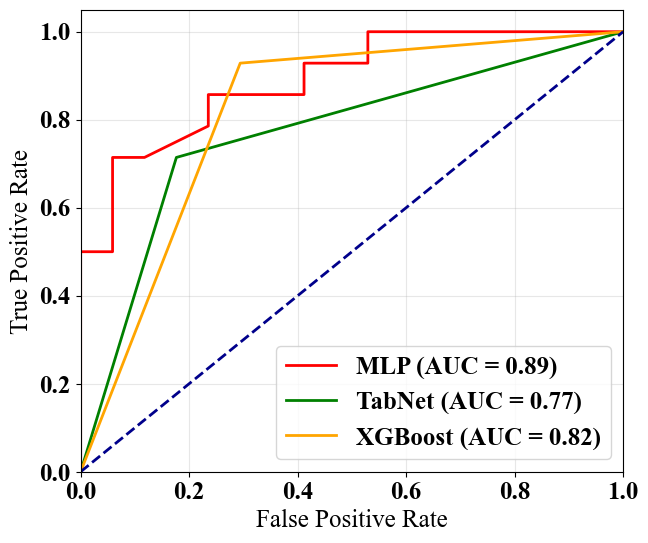

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.rcParams.update({'font.family': 'Times New Roman', 'font.weight': 'bold', 'font.size': 18})

# Get predicted probabilities for each model
y_pred_prob_mlp = mlp_finetune.predict(X_finetune_test)
y_pred_prob_tabnet = tabnet_finetuned.predict(X_B_test)  # Probabilities for the positive class (ROC)
y_pred_proba_xgb = xgb_finetune.predict(X_finetune_test) 

# Calculate ROC curve and AUC for each model
fpr_mlp, tpr_mlp, _ = roc_curve(y_finetune_test, y_pred_prob_mlp)
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_B_test, y_pred_prob_tabnet)
fpr_xgb, tpr_xgb, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)

# Calculate AUC for each model
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
roc_auc_tabnet = auc(fpr_tabnet, tpr_tabnet)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# fpr, tpr, _ = roc_curve(y_finetune_test, Dataset_B_Finetune)

# Also calculate using roc_auc_score for verification
roc_auc_score_mlp = roc_auc_score(y_B_test, y_pred_prob_mlp)
roc_auc_score_tabnet = roc_auc_score(y_B_test, y_pred_prob_tabnet)
roc_auc_score_xgb = roc_auc_score(y_B_test, y_pred_proba_xgb)

print(f"MLP AUC (auc function): {roc_auc_mlp:.4f}")
print(f"MLP AUC (roc_auc_score): {roc_auc_score_mlp:.4f}")
print(f"TabNet AUC: {roc_auc_tabnet:.4f}")
print(f"XGBoost AUC: {roc_auc_xgb:.4f}")

# Plot combined ROC curve
plt.figure(figsize=(7, 6))

# Plot each ROC curve
plt.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot(fpr_tabnet, tpr_tabnet, color='green', lw=2, label=f'TabNet (AUC = {roc_auc_tabnet:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')

# Adjust plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Combined ROC Curve for Fine-Tuned Models')
plt.legend(loc='lower right')

# Add grid for better readability
plt.grid(True, alpha=0.3)


# Save the combined ROC curve
plt.savefig('roc_curve_combined.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
plt.close()


In [ ]:
import matplotlib.pyplot as plt

# Data from your table
learning_rates = [0.001, 0.01, 0.1, 0.5]

# Model performance data
xgboost = {
    "Accuracy": [85.48, 88.71, 90.32, 83.87],
    "F1-Score": [84.85, 88.37, 89.66, 83.87],
    "Sensitivity": [85.71, 92.86, 92.86, 92.86],
    "Specificity": [85.29, 85.29, 88.24, 76.47]
}

tabnet = {
    "Accuracy": [80.65, 82.26, 83.87, 77.42],
    "F1-Score": [82.76, 83.33, 84.85, 78.79],
    "Sensitivity": [92.86, 100.00, 100.00, 85.71],
    "Specificity": [70.59, 70.59, 70.59, 70.59]
}

mlp = {
    "Accuracy": [83.87, 85.48, 87.10, 79.03],
    "F1-Score": [82.76, 84.21, 85.71, 78.13],
    "Sensitivity": [85.71, 85.71, 85.71, 78.57],
    "Specificity": [82.35, 85.29, 88.24, 79.41]
}

resnet = {
    "Accuracy": [85.48, 87.10, 88.71, 83.87],
    "F1-Score": [85.71, 87.18, 88.37, 84.21],
    "Sensitivity": [92.86, 92.86, 92.86, 92.86],
    "Specificity": [79.41, 82.35, 85.29, 76.47]
}

# List of models for iteration
models = ['XGBoost', 'TabNet', 'MLP', 'ResNet']
metrics = ['Accuracy', 'F1-Score', 'Sensitivity', 'Specificity']

# Plotting graphs for each model and metric
for model, data in zip(models, [xgboost, tabnet, mlp, resnet]):
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(learning_rates, data[metric], marker='P', linestyle='-', label=f'{model} - {metric}')
        plt.xlabel('Learning Rate')
        plt.ylabel(metric)
        plt.title(f'{model} - {metric} vs Learning Rate')
        plt.xscale('log')  # Log scale for better visualization if needed
        plt.xticks(learning_rates)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        # Save the image
        plt.savefig(f'{model}_{metric}_vs_learning_rate.png')
        plt.close()  # Close the plot to prevent overlapping with the next one
